In [1]:
import sys, os
sys.path.insert(0, '../')
from matplotlib import style
style.use('seaborn-poster')
import matplotlib.pyplot as plt, numpy as np, networkx as nx
from Utils.stats import driverNodeEstimate
from Utils import IO

fn = 'tester.pickle'
for k, v in IO.loadPickle(fn).items():
    print(f'Loading {k}')
    globals()[k] = v

s = next(iter(settings))
setting = settings[s]


Loading aucs
Loading data
Loading rata
Loading settings
Loading coeffs


In [3]:
%load_ext autoreload
%autoreload 2
from scipy.stats import percentileofscore as pcs
# estimate the max values
# tmp = np.array([i for i in aucs.values()])

from itertools import product
# ndata, nodes, ntrials, npulse, ntemp = tmp.shape
npulse = len(setting.get('pulseSizes')) + 1
ntemp  = len(setting.get('equilibrium')['ratios'])
    
alpha = .05
centralities = dict(\
                   degree = nx.degree_centrality,\
                   betweenness = nx.betweenness_centrality,\
                   closeness  = nx.closeness_centrality,\
                   eigenvector = nx.eigenvector_centrality,\
                   )

structuralData = {}
for k, setting in settings.items():
    m = setting.get('model')
    g = m.graph
    
    buffer = np.zeros((m.nNodes))
    centData = {}
    for condition, cf in centralities.items():
        c = cf(g)
        for node, val in c.items():
            idx = m.mapping[node]
            buffer[idx] = val
        MAX = buffer.max()
        cdrivers = np.where(buffer == MAX)[0]
        centData[condition] = cdrivers
    structuralData[k] = centData

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Estimate driver-nodes

In [4]:
alldrivers = {}
total = int(1e4)
batch = 50
alpha = 0.5
from Utils.stats import bootStrapAll, returnX
from tqdm import tqdm_notebook as tqdm
for k, v in tqdm(aucs.items()):
    v = np.moveaxis(v, 0, 1)
    alldrivers[k] = \
    bootStrapAll(v, returnX, total, batch, alpha)
    

<ipython-input-4-b2903466e8d1>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k, v in tqdm(aucs.items()):


# Compute Jaccard score

In [5]:
from Utils.stats import computeMatchScore 
%load_ext autoreload
%autoreload 2
conditions = len(centralities) + 1
overlaps = {}
driverSizes = {}
for k, v in alldrivers.items():
    s = v.shape[:-1]
    print(s, v.shape)
    npulse, _ = s 
    ti = np.array([i for i in \
                   structuralData[k].values()], \
                  dtype = list)
    
    mip = np.array([list(i.keys()) for i in v[..., 0].flat]).reshape(s)
    tmp = np.zeros((conditions + 1, npulse - 1, ntemp),\
                   dtype = list)
    
#     print(tmp.shape, mipf.shape) 
    tmp[0] = mip[1:]
    tmp[1] = mip[0]
    s = tmp.shape
    tmp = tmp.reshape(conditions + 1, -1)
    for condition in range(conditions - 1):
        for j in range(len(tmp.T)):
            tmp[condition + 2, j] = ti[condition]
            
    # convert all lists to iterable
    ss = tmp.shape
    tmp = tmp.reshape(-1)
    for idx, i in enumerate(tmp):
        try:
            iter(i)
        except TypeError:
            tmp[idx] = [i]
    tmp = tmp.reshape(ss) 
    tmp = tmp.reshape(s)
    overlaps[k] = computeMatchScore(tmp)
    driverSizes[k] = np.array([len(i) for i in tmp.flat]).reshape(tmp.shape)
    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(11, 3) (11, 3, 2)
(11, 3) (11, 3, 2)
(11, 3) (11, 3, 2)
(11, 3) (11, 3, 2)
(11, 3) (11, 3, 2)
(11, 3) (11, 3, 2)
(11, 3) (11, 3, 2)
(11, 3) (11, 3, 2)
(11, 3) (11, 3, 2)
(11, 3) (11, 3, 2)
(11, 3) (11, 3, 2)
(11, 3) (11, 3, 2)
(11, 3) (11, 3, 2)
(11, 3) (11, 3, 2)
(11, 3) (11, 3, 2)
(11, 3) (11, 3, 2)


<ipython-input-7-8203aea002a8>:84: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


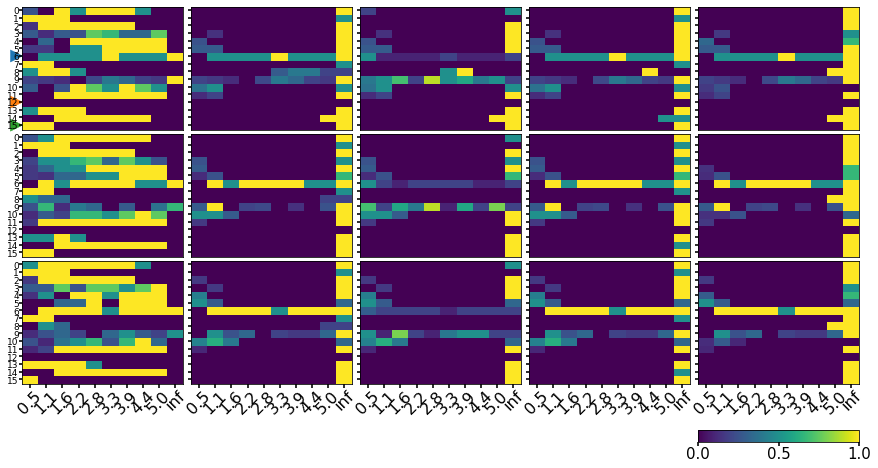

In [7]:
# show results
tmpO = np.array([i for i in overlaps.values()])
%matplotlib inline
hs = np.ones(5)
hs[-2] = .3
hs[-1] = .1
gs = dict(\
         height_ratios = hs,\
         )

figsize = (15, 8)
fig, ax = plt.subplots(5, 5, figsize = figsize, \
#                        sharex = 'row', sharey = 'row',\
                      gridspec_kw = gs)
t  = ['/var/scratch/cveltere/tester/2019-10-16T10:54:59.050361',\
          '/var/scratch/cveltere/tester/2019-10-14T07:47:19.581611',\
          '/var/scratch/cveltere/tester/2019-10-16T15:57:27.814220']

targets = {}
idx = 0
for jdx, k in enumerate(overlaps.keys()):
    if k in t:
        targets[k] = jdx
        idx += 1

pulses = np.array(next(iter(settings.values())).get('pulseSizes')).round(1)

labels = ['Informational\n impact', *centralities.keys()]

from itertools import product

ntemp = 3
cmap = plt.cm.viridis
colorsGraphs = plt.cm.tab10(range(len(t)))
for (condition, temp) in product(*map(range, ax.shape)):
    axj = ax[temp, condition]
    if condition < conditions  and temp < ntemp:
        # setup axes
        axj.set_xticks(np.arange(len(pulses)))
        axj.set_xticklabels(pulses, rotation = 45, fontsize = 16)
        axj.tick_params(axis = 'x', pad = 0)
        xr = np.arange(len(aucs) + 1)
        w = np.diff(xr)[0] /(xr.size *.5)
        axj.set_yticks(xr - w)

        if condition == 0:
            axj.set_yticklabels(xr, fontsize = 9)
            axj.tick_params(axis = 'y', pad = 0, zorder = 5)
        else:
            axj.set_yticklabels([])
        if condition < conditions  and temp < ntemp - 1:
            axj.set_xticklabels([])
            axj.set_xticks([])
            
        # imshow
        h = axj.imshow(tmpO[..., condition + 1, :, temp],\
                       vmin = 0, vmax = 1,\
                       cmap = cmap,\
                           alpha = 1,
                       aspect = 'auto',\
                          )
        if temp == 0 :
            if condition == 0:
                for puti, (k, put) in enumerate(targets.items()):
                    axj.annotate('', (-.45, put - w),  \
                             xytext=(-.5, put + - w), \
                             arrowprops=dict(arrowstyle="-|>",
                             connectionstyle="arc3",\
                            mutation_scale = 30,\
                            color = colorsGraphs[puti],\
                            zorder =1), zorder  = 1)

    else:
        axj.axis('off')
m = ax[-1,-1]
m.axis('on')
m.set_xlabel('Avg. Percentile score')
m.tick_params(axis = 'x', pad = 0, size = 4)

fig.subplots_adjust(wspace = 0.05, hspace = .05)
fig.colorbar(h, cax = m, orientation = 'horizontal').ax.tick_params(labelsize = 15)
fig.savefig('overlap_main.svg', bbox_inches = 'tight',\
           pad_inches = 0, transparent = 1, dpi = 300)
fig.show()


(16, 10, 3, 6)
(16, 11, 3, 5)


<ipython-input-17-28f6f08d1a78>:63: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


[[[1 1 1]
  [1 1 1]
  [1 1 1]
  [1 1 1]
  [1 1 1]
  [1 1 1]
  [1 1 1]
  [1 1 1]
  [1 1 1]
  [1 1 1]]

 [[1 1 1]
  [1 1 1]
  [1 1 1]
  [1 1 1]
  [1 1 1]
  [1 1 1]
  [1 1 1]
  [1 1 1]
  [1 1 1]
  [1 1 1]]

 [[1 1 1]
  [1 1 1]
  [1 1 1]
  [1 1 1]
  [1 1 1]
  [1 1 1]
  [1 1 1]
  [1 1 1]
  [1 1 1]
  [1 1 1]]

 [[3 3 4]
  [3 3 4]
  [3 3 4]
  [3 3 4]
  [3 3 4]
  [3 3 4]
  [3 3 4]
  [3 3 4]
  [3 3 4]
  [3 3 4]]

 [[1 1 1]
  [1 1 1]
  [1 1 1]
  [1 1 1]
  [1 1 1]
  [1 1 1]
  [1 1 1]
  [1 1 1]
  [1 1 1]
  [1 1 1]]

 [[1 1 1]
  [1 1 1]
  [1 1 1]
  [1 1 1]
  [1 1 1]
  [1 1 1]
  [1 1 1]
  [1 1 1]
  [1 1 1]
  [1 1 1]]

 [[2 2 2]
  [2 2 2]
  [2 2 2]
  [2 2 2]
  [2 2 2]
  [2 2 2]
  [2 2 2]
  [2 2 2]
  [2 2 2]
  [2 2 2]]

 [[1 1 1]
  [1 1 1]
  [1 1 1]
  [1 1 1]
  [1 1 1]
  [1 1 1]
  [1 1 1]
  [1 1 1]
  [1 1 1]
  [1 1 1]]

 [[1 1 1]
  [1 1 1]
  [1 1 1]
  [1 1 1]
  [1 1 1]
  [1 1 1]
  [1 1 1]
  [1 1 1]
  [1 1 1]
  [1 1 1]]

 [[2 3 4]
  [2 3 4]
  [2 3 4]
  [2 3 4]
  [2 3 4]
  [2 3 4]
  [2 3 4]
  [2 3 4]
  

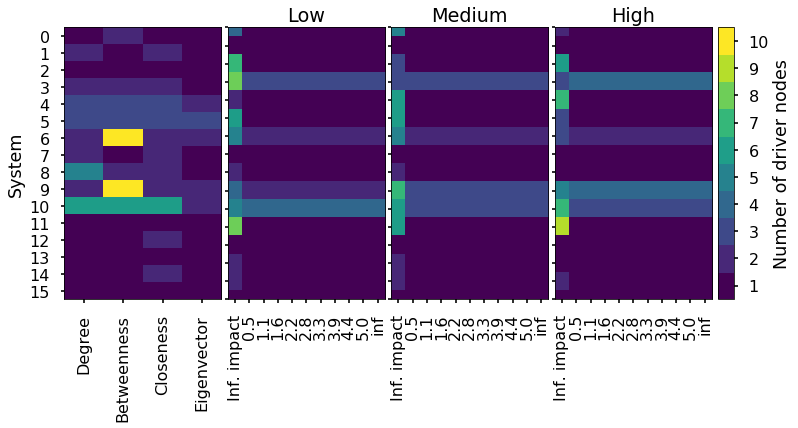

In [17]:
DRIVERSIZES = np.array([i for i in driverSizes.values()])

DRIVERSIZES = np.moveaxis(DRIVERSIZES, 1, -1)
print(DRIVERSIZES.shape)
from matplotlib import gridspec
import matplotlib
from_list = matplotlib.colors.LinearSegmentedColormap.from_list

n = 10
cmap = plt.cm.get_cmap('viridis', n)

ndata, npulse, ntemps, conditions = DRIVERSIZES.shape

tmp = np.zeros((ndata, npulse + 1, ntemps, conditions - 1))

tmp[..., 0,  :, 0] = DRIVERSIZES[:, 0, :, 0]
tmp[..., 1:, :, 0] = DRIVERSIZES[..., 1]
centDrivers = DRIVERSIZES[:, 0, 0, 2:]


wr = np.ones(5)
wr[-1] = .1
gs = dict(width_ratios = wr)
fig, ax = plt.subplots(1, ntemps + 2,\
                       figsize = (12, 5),\
                      gridspec_kw = gs)
axi = ax[0]

labels = [i.capitalize() for i in centralities]
xr = np.arange(len(labels))
axi.set_xticks(xr)
axi.set_xticklabels(labels, rotation = 90)
yr  = np.arange(ndata)
axi.set_yticks(yr)
axi.set_ylabel('System')

axi.imshow(centDrivers, aspect = 'auto')
tpulse = ['Inf. impact', *pulses.round(1)]
print(tmp.shape)

titles = 'Low Medium High'.split()
for tidx, axi in enumerate(ax[1:-1]):
    h = axi.imshow(tmp[..., tidx, 0], \
                   aspect = 'auto', cmap = cmap, \
                   vmin = 1, vmax = n+1)
    xr =  np.arange(len(tpulse))
    axi.set_xticks(xr)
    axi.set_xticklabels(tpulse, rotation = 90,\
                        )
    axi.set_yticklabels([])
    axi.set_yticks(yr)
    axi.set_title(titles[tidx])
    
fig.subplots_adjust(wspace = .05, hspace = .05)
yl = np.arange(1, n + 1)
cbar = fig.colorbar(h, cax = ax[-1], ticks = yl + .5, \
            label = 'Number of driver nodes')
ax[-1].set_yticklabels(yl)

fig.savefig('numberDriver.pdf', \
           pad_inches = 0,\
           bbox_inches = 'tight')
fig.show()

print( DRIVERSIZES[..., 1])

Using circular_layout
Using circular_layout
Using circular_layout


<ipython-input-9-87a4042a08c2>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


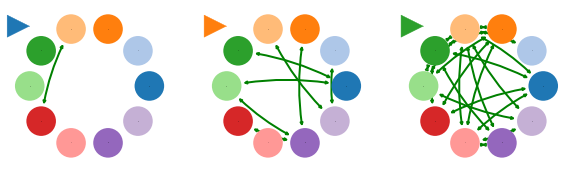

In [9]:
from Utils.plotting import addGraphPretty
fig, ax = plt.subplots(1, 3, figsize = (10,10))
c = plt.cm.tab10(range(3))
start = -1
up = 1
for idx, (target, jdx) in enumerate(targets.items()):
    tax = ax[idx]
    color = c[idx]
    g = settings.get(target).get('graph')
    addGraphPretty(g, ax = tax)
    
    tax. annotate('', (start, up), xytext = (start - .01, up),\
               arrowprops=dict(arrowstyle="-|>",
                 connectionstyle="arc3",\
                mutation_scale = 55, color = color),\
                transform  = tax.transData)
    tax.axis('off') 
    tax.set(frame_on = 0)
fig.savefig('annotate graphs.svg', bbox_inches = 'tight',\
           pad_inches = 0, transparent = 1)
fig.show()

(10, 50, 11, 3, 14)
(10, 50, 11, 3, 14)
(10, 50, 11, 3, 14)


<ipython-input-15-8eaacef00c9f>:84: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


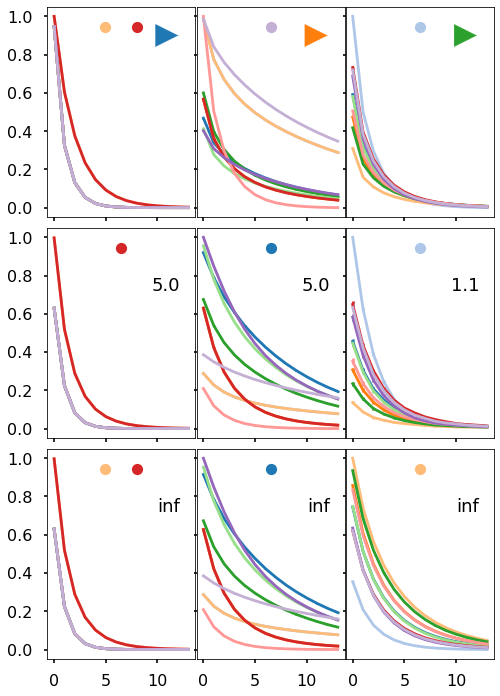

In [15]:
# make panel highlighting a transition of driver-nodes for nudge sizes
from scipy.stats import sem
# make panel highlighting a transition of driver-nodes for nudge sizes
dataname = '/var/scratch/cveltere/tester/2019-10-16T15:57:27.814220'
tmp = data[dataname]
nodes, trials, pulses, temps, deltas = tmp.shape
fig, ax = plt.subplots(3, 3, figsize = (8, 12),\
                      sharey = 'all', sharex =  'all')
mainax = fig.add_subplot(111, frameon = 0,\
                        xticks = [], \
                        yticks = [], \
                        )
# mainax.set_xlabel('Time (step)', labelpad = 32)

xr = np.arange(tmp.shape[-1])
idx = [[0, -2, -1], [0, -2, -1], [0, 1, -1]]

pulses = settings[dataname].get('pulseSizes')
# labels = ['Mutual\ninformation',\
#          ]

graph = settings[dataname].get('graph')
colors = plt.cm.tab20(range(graph.number_of_nodes()))

start = 12
up    = .9

datanames = list(targets.items())

cColors = plt.cm.tab10(range(10))
for didx, (dataname, puti) in enumerate(datanames):
    tmp = data.get(dataname)
    print(tmp.shape)
    drivers = alldrivers[dataname]
#     print(drivers.shape); assert 0
    for i in range(3):
        axi = ax[i, didx]

        j = idx[didx][i]
        
        driver = set(drivers[j, 0, 0].keys())
        if i == 0: 
            color = colors[i]
#             ddix = targets.get(dataN)
            axi.annotate('', (start, up), xytext = (start - .01, up),\
                   arrowprops=dict(arrowstyle="-|>",
                     connectionstyle="arc3",\
                    mutation_scale = 55, color = cColors[didx]),\
                    transform  = axi.transAxes)

        else :
            axi.text(.9, .7, '' if i == 0 else np.round(pulses[j],1), fontsize = 18, \
                     horizontalalignment = 'right', \
                     transform = axi.transAxes)
        elems = []
        for k in range(nodes):
            if k in driver:
                elem = plt.Line2D([], [], marker = 'o',\
                                 linestyle = 'none',\
                                 color = colors[k],\
                                 )
                elems.append(elem)
            
            axi.errorbar(xr, tmp.mean(1)[k, j, 0], 2 * sem(tmp, 1)[k, j, 0], \
                     color = colors[k])
        axi.legend(handles = elems, fancybox = 0,\
                  bbox_to_anchor = (.5, .9), loc = 'center', ncol = 10,\
                  framealpha = 0, borderaxespad = 0,\
                  handletextpad = 0, columnspacing = 0)
#     axi.set_title(labels[i], fontsize = 15)
elems = []
for k in range(nodes):
    elems.append(plt.Line2D(\
                            [], [],\
                            color = colors[k],\
                            marker = 'o',\
                            linestyle = 'none',\
                           label =  k))
fig.subplots_adjust(hspace = .05, wspace = .01)
# axi.legend(handles = elems, loc ='upper left', bbox_to_anchor = (1, 1.02), \
#           frameon = 0, borderaxespad = 0, \
#            handletextpad = 0, title = 'Node', title_fontsize = 15)
fig.savefig('example.svg', bbox_inches = 'tight', pad_inches = 0) 
fig.show()



In [19]:
from Utils.stats import ratio, bootStrap
OVERLAPS = np.array([i for i in overlaps.values()])
# remove the controls (all 1s)
OVERLAPS = OVERLAPS[:, 1:]

# move conditions to the back
OVERLAPS = np.moveaxis(OVERLAPS, 1, -1)
print(OVERLAPS.shape)
ndata, npulse, ntemps, conditions = OVERLAPS.shape

error = 1e-16
OVERLAPS += error


inp = OVERLAPS.reshape(-1, conditions) 
print(len(inp))
# print(overlaps.shape); assert 0
N   = int(1e4)
Nbc = int(1e2)
# Nbc = len(inp)

def ration(x):    
    return   x[..., [0]] / x[..., 1:] 
boots = bootStrap(inp, ration, total = N, batch = len(inp))

inp = np.moveaxis(OVERLAPS, 2, 1)
print(inp.shape)
inp = inp.reshape(-1, npulse, conditions)
print(inp.shape)
hboots = bootStrap(inp, ration, total = N, batch = len(inp))
print('Done')

(16, 10, 3, 5)
480
(16, 3, 10, 5)
(48, 10, 5)
Done


In [20]:
interval = (0, 1) # target forratio

# be mindful of the indices
allSets = np.concatenate((hboots, boots[:, None]), axis = 1)

binned = np.zeros((*allSets.shape[1:], 2), dtype = list)
for (condition, predictor) in product(*map(range, binned.shape[:2])):
    c, b = np.histogram(allSets[..., condition, predictor], bins = 30, density = 1)
    b = (b[:-1] + b[1:])/2
    binned[condition, predictor] = c, b
# estimate density functions
from scipy.stats import norm

# gest worst distributions
worst = abs( allSets.mean(0)).argmin(-1)
# print(tmp.mean(0))
# print(worst, tmp.shape)
worst = np.array([allSets[...,idx, i] for idx, i in enumerate(worst)])

kdeFits = np.zeros((worst.shape[-1], 2))
for idx, di in enumerate(worst):
    kdeFits[idx] = norm.fit(di)

(11, 4, 2)
(11, 4, 2)


<ipython-input-21-d906d9ac61dc>:61: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  axi.annotate(np.round(pulses[condition], 1),\
<ipython-input-21-d906d9ac61dc>:87: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


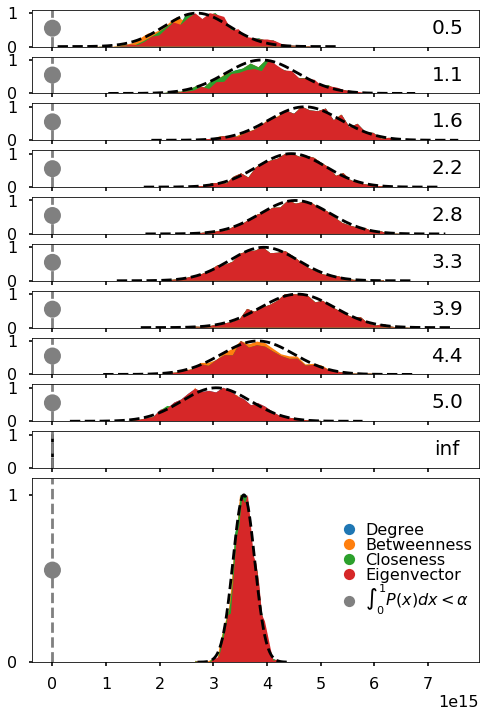

In [21]:
print(binned.shape)
from matplotlib import patches
hs = np.ones(11)
hs[-1] = 5
gs = dict(\
         height_ratios = hs,\
         )

%matplotlib inline
fig, ax = plt.subplots(11, gridspec_kw = gs, \
                       figsize = (8, 12),\
                      sharex = 'all',\
                      )
alpha = .001
print(binned.shape)
for condition in range(11):
    axi = ax[condition]
    # get all the conditions
    for c, b in binned[condition]:
#         print(c, b)
        c = (c - c.min()) / (c.max() - c.min())
        axi.fill_between(b, 0, c, alpha = 1)
    
    mean, loc = kdeFits[condition]
    
    start = 1e-5
    left, right = [norm.ppf(i, mean, loc) for i in (start, 1 - start)]
    xr = np.linspace(left, right, 1000)
    
    y = norm.pdf(xr, mean, loc)
    y = (y - y.min()) / (y.max() - y.min())
    axi.plot(xr, y, linestyle = 'dashed', color = 'k')
    
    if i != 10:
        axi.set_ylim(0, 1.1)
    else:
        axi.set_ylim(0, 1.1)
#     axi.set_xlim(0, 10)
#     axi.set_xscale('symlog')
    axi.axvline(1, color = 'gray', linestyle = 'dashed')
    axi.set_yticks([0, 1]) 
    
    pvalue = norm.cdf(1, mean, loc)
#     print(pvalue)
    if pvalue < alpha:
        bbox_props = dict(boxstyle="circle",\
                        ec = 'gray', lw=2,\
                        pad = 0, \
                        fc = 'gray')

        xi, xj, yi, yj = axi.axis()
        
        axi.annotate(' ', (1, axi.axis()[-1] / 2), fontsize = 15, \
                     verticalalignment = 'center',\
                    horizontalalignment = 'center', \
                     bbox = bbox_props,\
                    )
    if condition < len(pulses):
#         axi.text(axi.axis()[1] * .8, axi.axis()[-1] / 2, pulses[condition].round(1), fontsize = 20, \
#                  verticalalignment = 'center', horizontalalignment = 'center')
        axi.annotate(np.round(pulses[condition], 1),\
                     (.93, .5),\
                    verticalalignment = 'center',\
                    horizontalalignment = 'center',\
                     textcoords = 'axes fraction',\
                     fontsize = 20,\
        )

elems = []
colors = plt.cm.tab10(range(4))
for idx, c in enumerate(centralities):
    elems.append(plt.Line2D([], [], marker = 'o', linestyle = 'none',\
                           color = colors[idx],\
                           label = c.capitalize()))
elems.append(plt.Line2D([], [], marker = 'o', linestyle = 'none',\
                       color = 'gray',\
                       label = '$\int_0^1 P(x) dx < \\alpha$'))
axi.legend(handles = elems, loc = 'center right', borderaxespad = 0,\
          handletextpad = 0, frameon = 1,\
          edgecolor = 'white',\
          facecolor = 'white',\
          framealpha = 0,\
          labelspacing = 0)
fig.subplots_adjust(hspace = .2)
fig.savefig('new_conditionals.svg', bbox_inches = 'tight',\
           pad_inches = 0)
fig.show()

# Time-plots and jaccard drivers

<IPython.core.display.Javascript object>


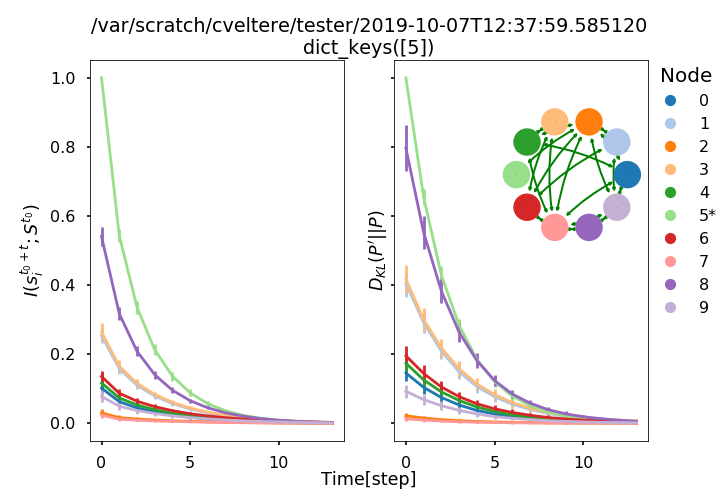

interactive(children=(Select(description='dataName', options=('/var/scratch/cveltere/tester/2019-10-07T12:37:5…

In [16]:

import ipywidgets as widgets
from scipy.stats import sem
from Utils.plotting import addGraphPretty

# dataSlider = widgets.SelectionSlider(options = data.keys())
dataSlider = widgets.Select(options = data.keys())
tempSlider = widgets.IntSlider(min = 0, max = 2)


pulseSlider = widgets.IntSlider(min = 1, max = npulse - 1)


%matplotlib notebook
fig, (left, right) = plt.subplots(1, 2, figsize = (10, 7), sharey = 'all')
mainax = fig.add_subplot(111, frameon = 0,\
                        xticks = [],\
                        yticks = [])
mainax.set_xlabel('Time[step]', labelpad = 30)
# inax.axis('off')
@widgets.interact(dataName = dataSlider, \
                  temp = tempSlider, \
                  pulse = pulseSlider)
def update(dataName, temp, pulse):
    d = rata.get(dataName)
    
    for idx, i in enumerate(data.keys()):
        if i == dataName:
            break
    print(alldrivers[dataName].shape)
    drivers = alldrivers[dataName][pulse, temp, 0]
    
    mainax.set_title(dataName + "\n" + str(drivers.keys()))
    g = settings.get(dataName).get('graph')
    
    nodes, trials, pulses, temps, deltas = d.shape
    colors = plt.cm.tab20(range(nodes))
    means = d.mean(1)
    sems  =  2 * np.std(d, axis = 1)
    xr = np.arange(d.shape[-1])
    
    left.cla(); right.cla()
    
    inax = right.inset_axes([.4, 0.4, .6, .6])
    addGraphPretty(g, ax = inax)
    inax.axis('off')
    for node in range(nodes):
        left.errorbar(xr, means[node, 0, temp], \
                      sems[node, 0, temp], \
                      color = colors[node],\
                      label = node)
        right.errorbar(xr, means[node, pulse, temp], \
                       sems[node, pulse, temp], \
                       color = colors[node],\
                       label = node)
    
    
    elems = [\
             plt.Line2D([], [], color = colors[node], \
                  label = f'{node}{"*" if node in drivers else ""}', \
                  marker = 'o', linestyle = 'None')\
                  for node in range(nodes)\
          ]
    left.set_ylabel(r'$I(s_i^{t_0 + t} ; S^{t_0})$')
    right.set_ylabel(r"$D_{KL}(P' \vert \vert P)$")
    right.legend(handles = elems, \
                 bbox_to_anchor = (1.0, 1), loc = 'upper left',\
                title = 'Node', title_fontsize = 20,\
                frameon = 0,\
                borderaxespad = 0)
fig.show(0)